# Reparametrization of Curves 

In [5]:
# Remove from public version
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Default Reparametrization (Immersion, Infinity)

In [6]:
from pathlib import Path

import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt


from funcshape.networks import CurveReparametrizer
from funcshape.layers.sineseries import SineSeries
from funcshape.loss import CurveDistance
from funcshape.logging import Logger
from funcshape.testlib.curves import Infinity, LogStepDiff
from funcshape.transforms import Qmap1D
from funcshape.reparametrize import reparametrize
from funcshape.utils import col_linspace
from funcshape.visual import plot_curve

### Display Figures Before Reparametrization

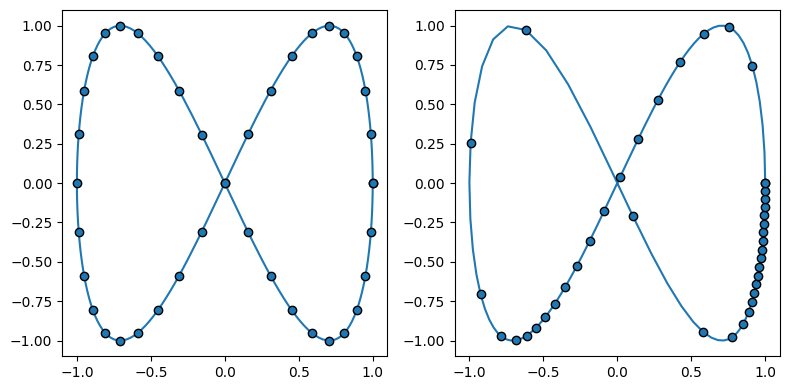

In [7]:
# Analytic diffeomorphism
g = LogStepDiff()

# Define Curves 
c1 = Infinity()
c2 = c1.compose(g)

# Get Qmaps (reparametrize c1 into c2(x) = c1(g(x)))
q, r = Qmap1D(c2), Qmap1D(c1)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plot_curve(c1, dotpoints=41, ax=plt.gca())
plt.subplot(122)
plot_curve(c2, dotpoints=41, ax=plt.gca())
plt.tight_layout()
plt.show()


Finished training in 2.16302s


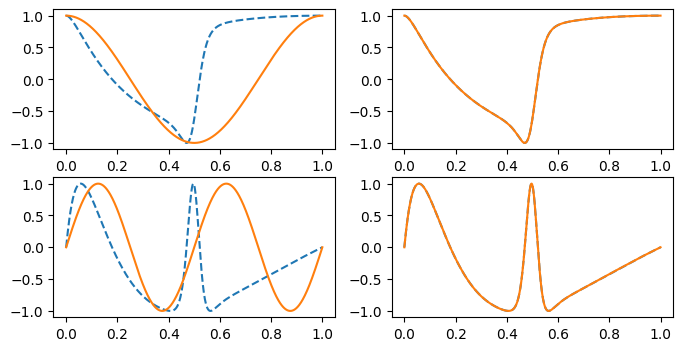

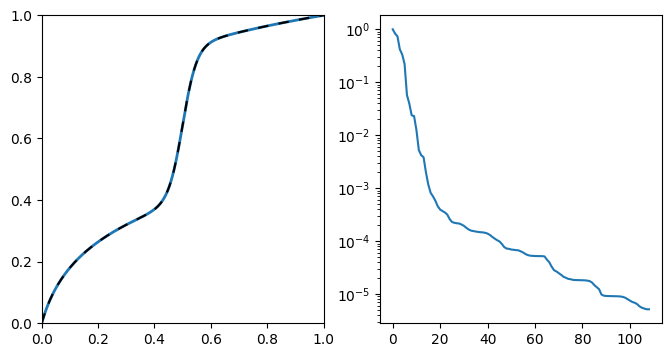

In [8]:
# Create reparametrization network
RN = CurveReparametrizer([
    SineSeries(10) for i in range(10)
])

# Define loss, optimizer and run reparametrization.
loss_func = CurveDistance(q, r, k=1024)
optimizer = optim.LBFGS(RN.parameters(), lr=1., max_iter=200, line_search_fn='strong_wolfe')
error = reparametrize(RN, loss_func, optimizer, 200, Logger(0))

# Get plot data to visualize diffeomorphism
RN.detach()
x = col_linspace(0, 1, 1024)
y = RN(x)

# Get curve-coordinates before and after reparametrization
C1, C2, C3 = c1(x), c2(x), c1(y)

# Plot coordinates before reparametrization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 4))
ax1.plot(x, C2[:, 0], ls="dashed")
ax1.plot(x, C1[:, 0])
ax3.plot(x, C2[:, 1], ls="dashed")
ax3.plot(x, C1[:, 1])

# Plot coordinates after reparametrization
ax2.plot(x, C2[:, 0], ls="dashed")
ax2.plot(x, C3[:, 0])
ax4.plot(x, C2[:, 1], ls="dashed")
ax4.plot(x, C3[:, 1])
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(x, y, lw=2)
ax1.plot(x, g(x), ls="--", c="black", dashes=(5, 5))
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax2.semilogy(error / error[0] )
plt.show()